<a href="https://colab.research.google.com/github/HanifAmeen/SE-44-Dermorax/blob/ML-Model--InceptionResNetV2/SDGP_CNN_Model_IRV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting the drive

In [94]:
#mounting the drive 
from google.colab import drive
drive.mount('/content/drive')
print("done")

Mounted at /content/drive
done


In [2]:
!nvidia-smi

Mon Mar 28 09:47:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import (concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,
                                     Activation,add,AveragePooling2D,BatchNormalization,Dropout)
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
path='C:\\Users\\Janidu Chathumina\\Desktop\\Dataset\\'

#Data Preprocessing

##Initializing the dataset

In [5]:
data_pd = pd.read_csv(path+'HAM10000_metadata')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [6]:
#counting the images per each class
def count_images_on_type(series):
    display(pd.DataFrame(series.value_counts()))

#class_list = ['akiec','bcc','bkl','df','mel','nv','vasc']
count_images_on_type(data_pd['dx'])


,dx
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [7]:
train_dir = os.path.join('HAM10000', 'train_dir')

test_dir = os.path.join('HAM10000', 'test_dir')


In [ ]:

#making the directories to store test and train data
os.mkdir(path+'train_dir')
os.mkdir(path+'test_dir')

In [8]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [9]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)
df_count.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1


In [10]:
#finding the duplicates to make sure none of these images have augmented duplicates

def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicate'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicate
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicate


In [11]:
#framing all the meta data
df_count = data_pd[data_pd['is_duplicate'] == 'no']
print(df_count)

         lesion_id      image_id     dx dx_type   age     sex localization  \
10     HAM_0001396  ISIC_0025276    bkl   histo  55.0  female        trunk   
15     HAM_0007207  ISIC_0031326    bkl   histo  65.0    male         back   
20     HAM_0006071  ISIC_0032343    bkl   histo  70.0  female         face   
33     HAM_0005612  ISIC_0024981    bkl   histo  80.0    male        scalp   
34     HAM_0005388  ISIC_0027815    bkl   histo  80.0    male        chest   
...            ...           ...    ...     ...   ...     ...          ...   
9988   HAM_0001036  ISIC_0027588  akiec   histo  50.0  female         face   
9990   HAM_0004462  ISIC_0027334  akiec   histo  45.0    male        trunk   
9991   HAM_0001152  ISIC_0030133  akiec   histo  65.0    male         face   
10001  HAM_0000020  ISIC_0031922  akiec   histo  60.0  female         face   
10008  HAM_0001576  ISIC_0033705  akiec   histo  60.0    male         face   

            dataset is_duplicate  
10     vidir_modern         

##Test Train Split 15% to 85%

In [12]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [13]:
#labels the data as test or train
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'


In [14]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
4407,HAM_0004436,ISIC_0030042,nv,follow_up,45.0,female,abdomen,vidir_molemax,no
5886,HAM_0001382,ISIC_0028922,nv,follow_up,80.0,male,lower extremity,vidir_molemax,no
5919,HAM_0002183,ISIC_0031912,nv,follow_up,65.0,male,back,vidir_molemax,no
6384,HAM_0000567,ISIC_0029677,nv,follow_up,35.0,male,trunk,vidir_molemax,no
2432,HAM_0007118,ISIC_0027856,vasc,consensus,45.0,female,trunk,vidir_molemax,no


In [15]:
#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicate,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicate,train


In [16]:
# adding to lists by image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [17]:
len(train_list)

9187

In [18]:
len(test_list)

828

In [19]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [20]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
#making the directories per each cancer type in test and train dir 
for i in targetnames:
  os.mkdir(path+"test_dir\\"+i)
  os.mkdir(path+"train_dir\\"+i)

###Copying the images to the test and the train folders

In [ ]:
#compying images to train folders
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join(path+'HAM10000\\',file_name)

    # copying the image from the source to target file
    target = os.path.join(path+'train_dir\\',label,file_name) 

    shutil.copyfile(source, target)

In [ ]:
#copying images to the test folders
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join(path+'HAM10000\\',file_name)

    # copying the image from the source to target file
    target = os.path.join(path+'test_dir\\',label,file_name)

    shutil.copyfile(source, target)

##Image Augmentation

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    
    os.mkdir(path+'aug_dir')
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join('aug_dir', 'img_dir')
    os.mkdir(path+'aug_dir\\img_dir')

    img_list = os.listdir(path+'train_dir\\' + img_class)

    # Copy images from the class train_dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join(path+'train_dir\\',img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(path+'aug_dir\\img_dir\\',file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = path+'aug_dir\\'

    # Augmented images will be saved to training directory
    save_path = path+'train_dir\\'+img_class

    # Creating Image Data Generator to augment images
    # Rotating,flipping and shifting the images to create augmented images.
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000 

    num_files = len(os.listdir(path+'aug_dir\\img_dir\\'))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree(path+'aug_dir')


Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [21]:
train_path = path+'train_dir'
test_path = path+'test_dir'
batch_size = 16

In [22]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [23]:
#To find the total number of images in the training batch and test batch.
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


#Model

##Downloading the InceptionResNetV2 Model

In [29]:
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
#To implement the own layers for the skin cancer classification.



In [30]:
#number of layers in irv2 model
len(irv2.layers)

782

In [31]:
irv2.layers

In [32]:
#remves the last three layers off
#removing upto the flatten layer
conv = irv2.layers[-28].output

In [33]:
#gets the output shape of the last layer
conv.get_shape

<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, 8, 8, 192) dtype=float32 (created by layer 'batch_normalization_398')>>

##Combining the Soft-Attention layer to the IRV2

In [34]:
#conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv  = Activation('relu')(conv)
conv = Dropout(0.3)(conv)

In [35]:
output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [36]:
#after adding these layers, number of layers = 759

##Compiling the model

In [37]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

##Model Summary

In [90]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_392 (Conv2D)             (None, 8, 8, 224)    129024      activation_391[0][0]             
__________________________________________________________________________________________________
batch_normalization_392 (BatchN (None, 8, 8, 224)    672         conv2d_392[0][0]                 
__________________________________________________________________________________________________
activation_392 (Activation)     (None, 8, 8, 224)    0           batch_normalization_392[0][0]    
__________________________________________________________________________________________________
conv2d_390 (Conv2D)             (None, 8, 8, 192)    399360      block8_6_ac[0][0]                
__________________________________________________________________________________________________
conv2d_393 (Conv2D)             (None, 8, 8, 256)    172032      activation_392[0][0]             
__________

#Model Evaluation Before Training

In [39]:
batch_size=16
#taking predictions from the trained model against the test images
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

In [40]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes



# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report BEFORE TRAINING for all 7 calsses :")
print("\n")
print(report)


Classification Report BEFORE TRAINING for all 7 calsses :


              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        23
         bcc       0.04      0.31      0.07        26
         bkl       0.06      0.02      0.02        66
          df       0.01      0.17      0.01         6
         mel       0.05      0.03      0.04        34
          nv       0.80      0.50      0.62       663
        vasc       0.00      0.00      0.00        10

    accuracy                           0.41       828
   macro avg       0.14      0.15      0.11       828
weighted avg       0.65      0.41      0.50       828



#Training the model

In [41]:
class_weights = {   
                    0 : 1.0,  ## akiec
                    1 : 1.0,  ## bcc
                    2 : 1.0,  ## bkl
                    3 : 1.0,  ## df
                    4 : 5.0,  ## mel
                    5 : 1.0,  ## nv
                    6 : 1.0,  ## vasc
                }

In [42]:
checkpoint_path =path+'Callbacks\\IRV2_CP.cpkt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    verbose=1
)

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=2, min_delta=0.001)

In [87]:
model.load_weights(checkpoint_path)

In [ ]:
batch_size=32

history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/batch_size),
                    epochs=15,
                    batch_size=batch_size,
                    validation_data=test_batches,
                    validation_steps=len(test_df)/batch_size,
                    callbacks=[cp_callback,Earlystop],
                    class_weight=class_weights)

Epoch 1/15
233/287 [=======================>......] - ETA: 3:58 - loss: 5.1425 - accuracy: 0.2023

In [73]:
model.save(path+'IRV2.h5')

#Model Evaluation after Training

In [88]:
batch_size=16
#taking predictions from the trained model against the test images
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)


In [89]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes



# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report AFTER TRAINING for all 7 calsses :")
print(report)


Classification Report AFTER TRAINING for all 7 calsses :
              precision    recall  f1-score   support

       akiec       0.77      0.43      0.56        23
         bcc       0.67      0.54      0.60        26
         bkl       0.52      0.77      0.62        66
          df       0.60      0.50      0.55         6
         mel       0.53      0.59      0.56        34
          nv       0.97      0.94      0.95       663
        vasc       1.00      1.00      1.00        10

    accuracy                           0.88       828
   macro avg       0.72      0.68      0.69       828
weighted avg       0.90      0.88      0.89       828



#Converting the model to a TfLite model

In [46]:
# Convert Keras model to TF Lite format using quantization.
#Quantization is the process of mapping continuous infinite values to a smaller set of discrete finite values
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\JANIDU~1\AppData\Local\Temp\tmpt10147wp\assets


In [47]:
# Show model size in MBs.
quantized_model_size = len(tflite_quantized_model) /1024/1024
print(quantized_model_size)

46.88665771484375


In [48]:
# Save the quantized model to files Downloads directory
f = open('IRV2.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the skin cancer classification model
#from google.colab import files
#files.download('IRV2.tflite')

print('IRV2.tflite has been downloaded')

IRV2.tflite has been downloaded


#Taking Cancer Predictions

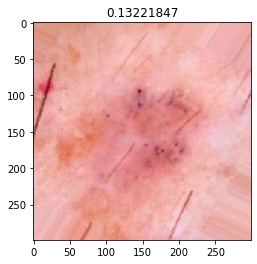

In [94]:
image_path=path+'train_dir\\bcc\\_0_212020.jpg'
img = image.load_img(image_path, target_size=(299, 299))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict(img)
plt.title((result[0][0]))
plt.show()